In [ ]:

import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tqdm

In [ ]:
# random point [0,1]
shape = 20000
x = torch.rand(shape)
y = torch.rand(shape)

# change [-10,10]
x = x * 20 - 10
y = y * 20 - 10

print(x.min(),x.max())
print(y.min(),y.max())

x=x[None,:]
y=y[None,:]

# function
def funct(x,y):
    return torch.sin(x+2*y)*torch.exp(-(2*x+y)**2)

tensor(-9.9993) tensor(9.9975)
tensor(-9.9974) tensor(9.9969)


In [ ]:

z = funct(x,y)

data = torch.concat([x,y,z])
data=data.t()
numpy_data = data.numpy()

df = pd.DataFrame(numpy_data,columns=['x','y','z'])
df

,x,y,z
0,1.337749,-2.612717,6.761050e-01
1,-8.144455,9.186237,-8.868063e-23
2,9.576639,0.739496,-0.000000e+00
3,-7.551011,8.485529,4.596529e-22
4,-1.698689,-8.989707,-0.000000e+00
...,...,...,...
19995,8.958374,0.171335,0.000000e+00
19996,-6.011105,6.977980,8.869642e-12
19997,-8.080130,-8.295398,0.000000e+00
19998,-3.762678,-1.408255,-6.370171e-36


In [ ]:
# разбиваем выборку на три части

train, test, val = torch.split(data,[int(shape * 0.7), int(shape * 0.15), int(shape * 0.15)])
print(f'train {train.shape[0]/data.shape[0]}')
print(f'test {test.shape[0]/data.shape[0]}')
print(f'validate {val.shape[0]/data.shape[0]}')

train 0.7
test 0.15
validate 0.15


In [ ]:
# определяем входные и целевые данные

input_train = train[:,:2]
input_test = test[:,:2]
input_val = val[:,:2]

target_value_train = train[:,2]
target_value_test = test[:,2]
target_value_val = val[:,2]

In [ ]:
# определяем модель

class NNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(in_features=2, out_features=50)
        self.act_1 = nn.LeakyReLU(0.1)
        self.linear_2 = nn.Linear(in_features=50,out_features=100)
        self.act_2 = nn.LeakyReLU(0.1)
        self.linear_3 = nn.Linear(in_features=100,out_features=200)
        self.act_3 = nn.LeakyReLU(0.2)
        self.linear_4 = nn.Linear(in_features=200,out_features=100)
        self.act_4 = nn.LeakyReLU(0.2)
        self.linear_5 = nn.Linear(in_features=100,out_features=1)

    def forward(self,x):
        x = self.linear_1(x)
        x = self.act_1(x)
        x = self.linear_2(x)
        x= self.act_2(x)
        x = self.linear_3(x)
        x = self.act_3(x)
        x = self.linear_4(x)
        x = self.act_4(x)
        x = self.linear_5(x)
        return x

# определяем устройство

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = NNModel().to(device)

Using cpu device


In [ ]:
# определяем оптимизатор и критерии оценки результата

optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.MSELoss()

In [ ]:
# функция для тренеровки

def train_model(model, optimizer, x, y, num_epochs = 50000):

  lst_loss = []; lst_iter = []

  model.train()
  for epoch_index in tqdm.tqdm(range(num_epochs)):

    # перемещаем входные данные на устройство
    x = x.to(device)
    y = y.to(device)

    # выполняем модель на входных данных
    preds = model(x)

    # рассчитываем потери
    loss = criterion(preds.squeeze(), y)

    if(epoch_index % 1000 == 0):
        lst_loss.append(loss.item())
        lst_iter.append(epoch_index)

    # выполняем обратное распространение
    optimizer.zero_grad()
    loss.backward()

    # обновляем параметры
    optimizer.step()

  sns.set_style("whitegrid", {
            "ytick.major.size": 0.1,
            "ytick.minor.size": 0.05,
            'grid.linestyle': '--'
         })

  plt.plot(lst_iter,lst_loss,)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('история функции потерь')

  0%|          | 0/50000 [00:00<?, ?it/s]

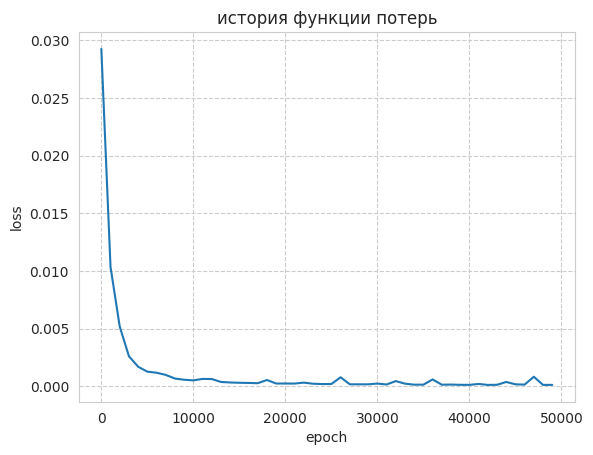

In [ ]:
train_model(model, optimizer, input_train, target_value_train)

In [ ]:
# функция для сравнения истенных и предсказанных значений
# с подсчетом метрики MSE

def compare_output(model,x,y,title:str):

    model.eval()
    sns.set_style("whitegrid", {
            "ytick.major.size": 0.2,
            "ytick.minor.size": 0.1,
            'grid.linestyle': '--'
         })

    x = x.to(device)
    y = y.to(device)

    # делаем предсказание
    y_pred = model(x)
    y2 = y_pred.detach()[:,0]
    mse_loss = criterion(y_pred.squeeze(), y)
    print(f'mse: {mse_loss}')

    plt.plot(y_pred.cpu().detach().numpy(),
             y.cpu().detach().numpy(), 'o', mec='k',ms=5)
    plt.xlabel('предсказанное значение')
    plt.ylabel('ожидаемое значение')
    plt.title(title)

mse: 0.00013967498671263456


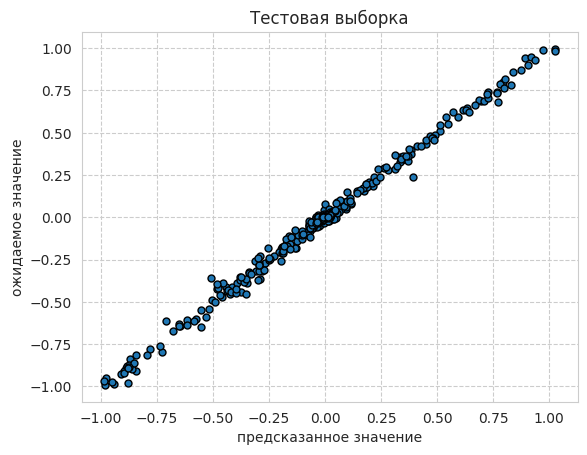

In [ ]:
compare_output(model,input_test,target_value_test,'Тестовая выборка')
plt.show()

In [ ]:
# функция для сравнения истенных и предсказанные значении

from mpl_toolkits.mplot3d import Axes3D

def compare_pred(model,x,y,title:str):

    model.eval()
    sns.set_style("whitegrid", {
            "ytick.major.size": 0.1,
            "ytick.minor.size": 0.05,
            'grid.linestyle': '--'
         })

    x = x.to(device)
    y = y.to(device)

    x1 = x[:,0].cpu()
    x2 = x[:,1].cpu()
    y1 = y.cpu()

    fig = plt.figure(figsize=(10,10))


    ax = fig.add_subplot(2, 2, 1, projection='3d')
    ax.plot_trisurf(x1, x2, y1, linewidth=0.0, edgecolors=None, alpha=0.2)
    ax.scatter(x1, x2, y1,edgecolor='red', linewidth=0.5, facecolor=None, s=5)
    ax.view_init(10, 50)
    ax.set_title('Истинные значения')


    y_pred = model(x)
    y2 = y_pred.cpu().detach().numpy()[:,0]
    mse_loss = criterion(y_pred.squeeze(), y)

    ax = fig.add_subplot(2, 2, 2, projection='3d')
    ax.plot_trisurf(x1, x2, y2, linewidth=0.0, edgecolors=None, alpha=0.2)
    ax.scatter(x1, x2, y2,edgecolor='green', linewidth=0.5, facecolor=None, s=5)
    ax.view_init(10, 50)
    ax.set_title('Предсказание модели')


    ax = fig.add_subplot(2, 2, (3, 4), projection='3d')
    ax.plot_trisurf(x1, x2, y2, linewidth=0.0, edgecolors=None, alpha=0.2)
    ax.scatter(x1, x2, y1,edgecolor='red', linewidth=0.5, facecolor=None, s=12)
    ax.scatter(x1, x2, y2,edgecolor='green', linewidth=0.5, facecolor=None, s=12)
    ax.view_init(10, 50)
    ax.set_title('Все значения')

    plt.suptitle(f'{title} : loss {mse_loss:.4f}')
    plt.show()

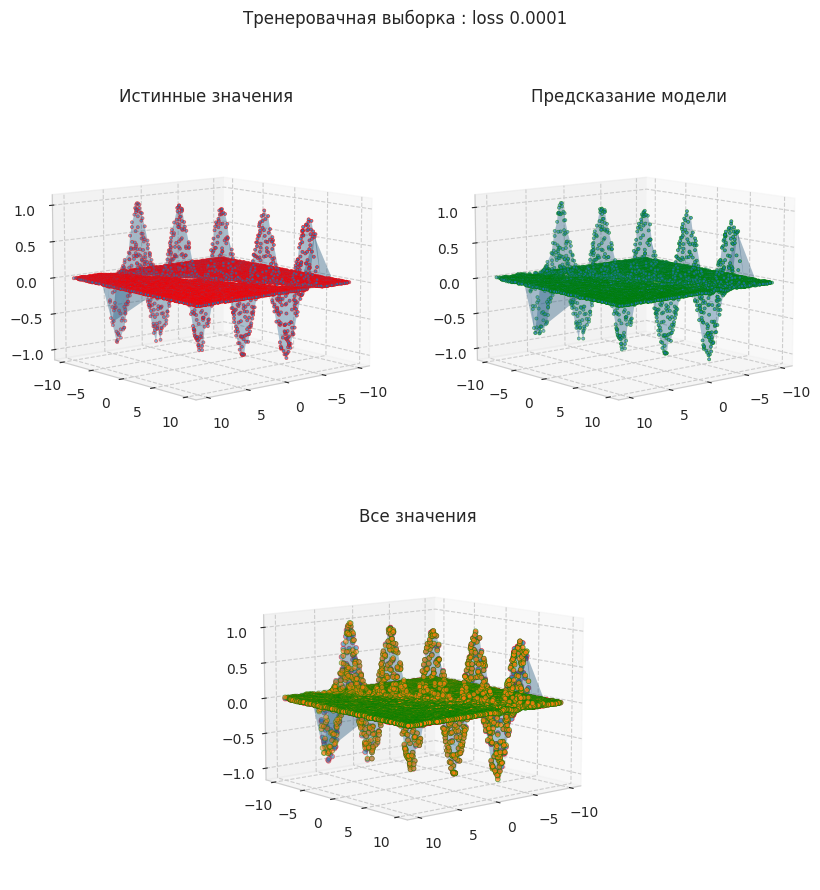

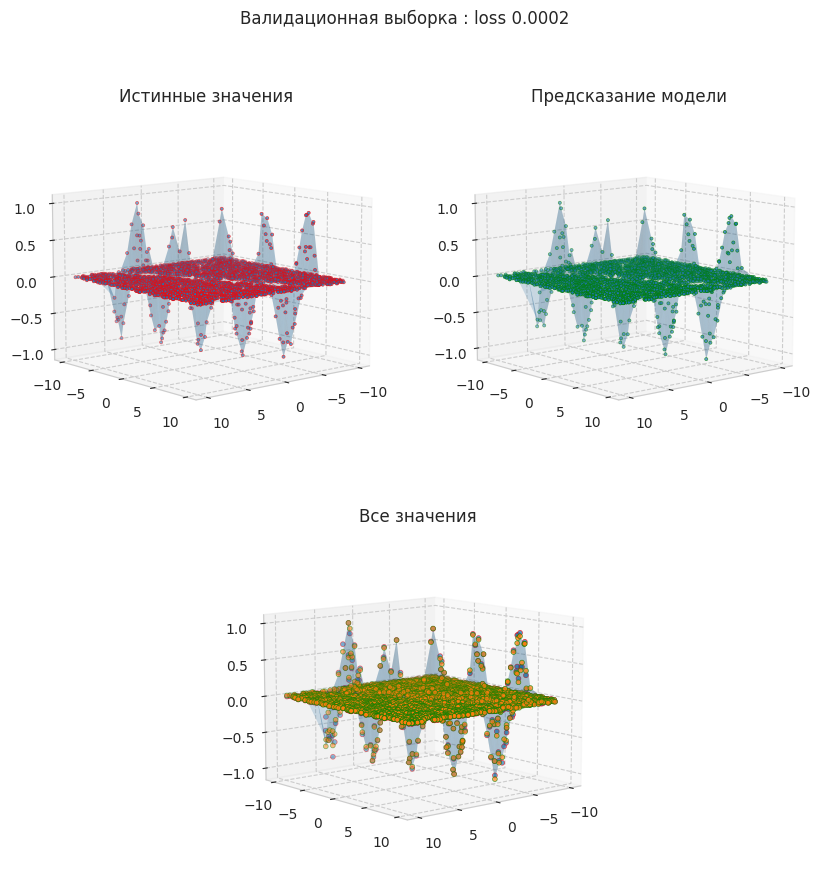

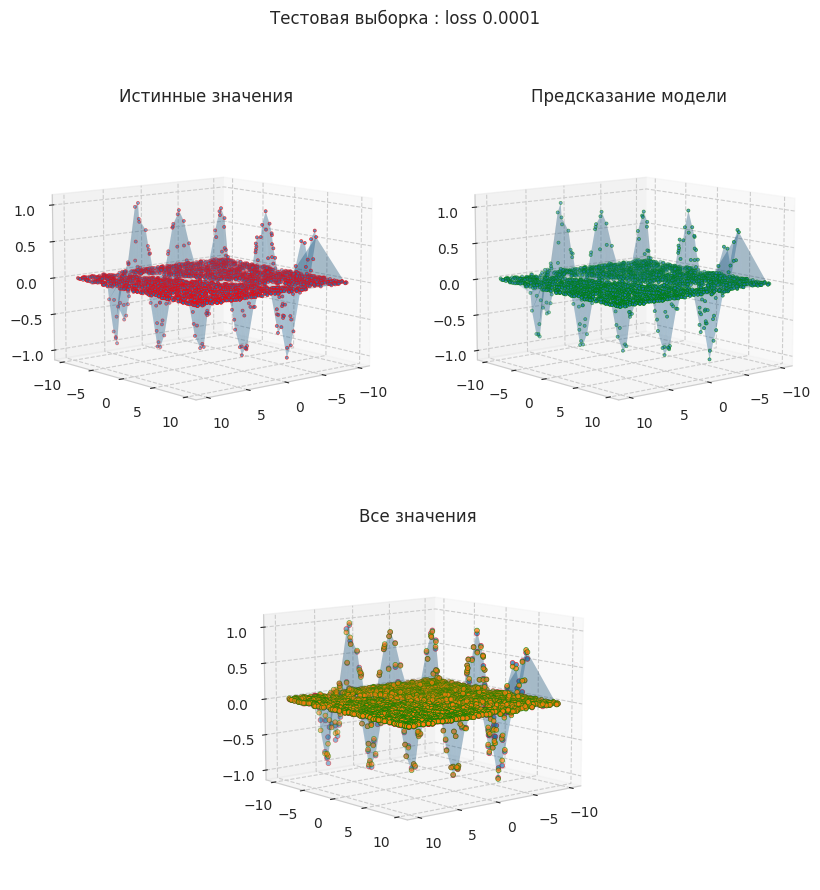

In [15]:
compare_pred(model,input_train,target_value_train,'Тренеровачная выборка'); plt.show()
compare_pred(model,input_val,target_value_val,'Валидационная выборка'); plt.show()
compare_pred(model,input_test,target_value_test,'Тестовая выборка'); plt.show()